In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
from pylab import rcParams
%matplotlib inline

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

In [17]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=382, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [12]:
#画像の表示
def display_img(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #cv2とmatplotlibではカラーの解釈が違う。
    plt.imshow(rgb)
    plt.show()

In [13]:
im_path = os.path.join('/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/pad_jpg/test_agm/64_64_ROTATE_90/', "ROTATE_90_ISIC_0052060.jpg")
im_path

'/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/pad_jpg/test_agm/64_64_ROTATE_90/ROTATE_90_ISIC_0052060.jpg'

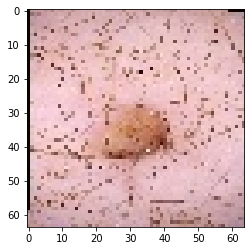

In [14]:
#im_path = os.path.join('/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/pad_jpg/test_agm/64_64_ROTATE_90/', "ROTATE_90_ISIC_0052060.jpg")
x = cv2.imread(im_path)
display_img(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


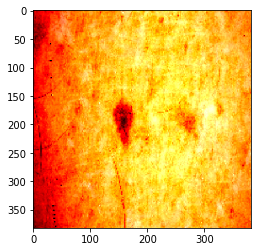

In [20]:
x_trs = train_transform(x)
x_trs = x_trs.permute(1, 2, 0)
x_trs = x_trs.to('cpu').detach().numpy().copy()
display_img(x_trs)

In [21]:
x.shape

(224, 224, 3)

In [22]:
x_trs.shape

(382, 382, 3)

## metadata

In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

In [3]:
#train_concatとtestに被るデータはない。
train_TD = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train_TD = train_TD.drop(['diagnosis','benign_malignant'], axis=1)
#train_TD = pd.read_csv(melanoma_external_malignant_256 + 'train_concat.csv')
test_TD  = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
sub_TD   = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')

train_TD.shape, test_TD.shape, sub_TD.shape

((33126, 6), (10982, 5), (10982, 2))

In [4]:
type(train_TD)

pandas.core.frame.DataFrame

In [5]:
train_TD.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0


In [11]:
patient_cnt = train_TD.groupby("patient_id").count()["image_name"]

In [12]:
patient_cnt.max()

115

In [13]:
patient_cnt.head()

patient_id
IP_0001230     6
IP_0019713    13
IP_0036322     5
IP_0038436     3
IP_0038545    28
Name: image_name, dtype: int64

In [25]:
train_TD_cut = train_TD[train_TD.patient_id == "IP_0038436"]
train_TD_cut.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
6704,ISIC_2102371,IP_0038436,male,55.0,torso,0
9154,ISIC_2838960,IP_0038436,male,55.0,lower extremity,0
12517,ISIC_3856233,IP_0038436,male,55.0,torso,0


In [28]:
train_tmp = []
train_tmp.append(train_TD_cut["image_name"])

In [29]:
train_tmp

[6704     ISIC_2102371
 9154     ISIC_2838960
 12517    ISIC_3856233
 Name: image_name, dtype: object]

## One-hot encode

In [103]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from kaggle.api.kaggle_api_extended import KaggleApi
import os

In [104]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

In [105]:
#train_concatとtestに被るデータはない。
train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train_df = train_df.drop(['diagnosis','benign_malignant'], axis=1)
test_df  = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
metaval_df  = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'metaval.csv')
metaval_df = metaval_df.drop(['diagnosis','benign_malignant'], axis=1)

train_df.shape, test_df.shape, metaval_df.shape

((24811, 6), (10982, 5), (8315, 6))

In [106]:
#start
dt = [train_df, metaval_df, test_df]

In [107]:
def TableDataPreprocess(dt):
    # One-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([dt[0]['anatom_site_general_challenge'], dt[1]['anatom_site_general_challenge'],
                       dt[2]['anatom_site_general_challenge']], ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    dt[0] = pd.concat([dt[0], dummies.iloc[:dt[0].shape[0]]], axis=1)
    dt[1] = pd.concat([dt[1], dummies.iloc[dt[0].shape[0]:dt[0].shape[0]+dt[1].shape[0]].reset_index(drop=True)], axis=1)
    dt[2] = pd.concat([dt[2], dummies.iloc[dt[0].shape[0]+dt[1].shape[0]:].reset_index(drop=True)], axis=1)
    for df in dt:
        df['sex'] = df['sex'].map({'male': 1, 'female': 0})
        df['sex'] = df['sex'].fillna(-1)
        df['age_approx'] /= df['age_approx'].max()
        df['age_approx'] = df['age_approx'].fillna(0)
        df['patient_id'] = df['patient_id'].fillna(0)
    return dt

In [108]:
[train_df, metaval_df, test_df] = TableDataPreprocess(dt)

In [109]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [110]:
meta_features

['sex',
 'age_approx',
 'site_head/neck',
 'site_lower extremity',
 'site_oral/genital',
 'site_palms/soles',
 'site_torso',
 'site_upper extremity',
 'site_nan']

In [111]:
train_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
0,ISIC_2637011,IP_7279968,1.0,0.500000,head/neck,0,1,0,0,0,0,0,0
1,ISIC_0015719,IP_3075186,0.0,0.500000,upper extremity,0,0,0,0,0,0,1,0
2,ISIC_0052212,IP_2842074,0.0,0.555556,lower extremity,0,0,1,0,0,0,0,0
3,ISIC_0068279,IP_6890425,0.0,0.500000,head/neck,0,1,0,0,0,0,0,0
4,ISIC_0074268,IP_8723313,0.0,0.611111,upper extremity,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24806,ISIC_9998682,IP_2516168,1.0,0.666667,head/neck,1,1,0,0,0,0,0,0
24807,ISIC_9998937,IP_3091321,1.0,0.444444,head/neck,0,1,0,0,0,0,0,0
24808,ISIC_9998965,IP_3293337,1.0,0.555556,torso,0,0,0,0,0,1,0,0
24809,ISIC_9999127,IP_9583707,1.0,0.222222,torso,0,0,0,0,0,1,0,0


In [112]:
metaval_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
0,ISIC_0452656,IP_3858753,1.0,0.388889,upper extremity,0,0,0,0,0,0,1,0
1,ISIC_0507189,IP_3858753,1.0,0.444444,lower extremity,0,0,1,0,0,0,0,0
2,ISIC_1144286,IP_3858753,1.0,0.444444,torso,0,0,0,0,0,1,0,0
3,ISIC_1199236,IP_3858753,1.0,0.444444,torso,0,0,0,0,0,1,0,0
4,ISIC_1303205,IP_3858753,1.0,0.444444,torso,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8310,ISIC_8609756,IP_1264754,0.0,0.722222,lower extremity,1,0,1,0,0,0,0,0
8311,ISIC_8620064,IP_1264754,0.0,0.722222,lower extremity,0,0,1,0,0,0,0,0
8312,ISIC_9212054,IP_1264754,0.0,0.722222,lower extremity,0,0,1,0,0,0,0,0
8313,ISIC_9659306,IP_1264754,0.0,0.722222,lower extremity,0,0,1,0,0,0,0,0


In [113]:
test_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
0,ISIC_0052060,IP_3579794,1,0.777778,NaN,0,0,0,0,0,0,1
1,ISIC_0052349,IP_7782715,1,0.444444,lower extremity,0,1,0,0,0,0,0
2,ISIC_0058510,IP_7960270,0,0.611111,torso,0,0,0,0,1,0,0
3,ISIC_0073313,IP_6375035,0,0.555556,torso,0,0,0,0,1,0,0
4,ISIC_0073502,IP_0589375,0,0.500000,lower extremity,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,1,0.444444,torso,0,0,0,0,1,0,0
10978,ISIC_9996992,IP_4890115,1,0.388889,torso,0,0,0,0,1,0,0
10979,ISIC_9997917,IP_2852390,1,0.277778,upper extremity,0,0,0,0,0,1,0
10980,ISIC_9998234,IP_8861963,1,0.722222,lower extremity,0,1,0,0,0,0,0


## Stackingの確認(ROC)

In [119]:
MV_192 = pd.read_csv(Output + 'metaval/sub_metaval_stacking_64_64.csv')

In [120]:
MV_192

,image_name,target
0,ISIC_2637011,2.542518e-04
1,ISIC_0015719,5.107879e-05
2,ISIC_0052212,2.654362e-05
3,ISIC_0068279,3.180563e-04
4,ISIC_0074268,3.063538e-09
...,...,...
32687,ISIC_9999134,0.000000e+00
32688,ISIC_9999320,0.000000e+00
32689,ISIC_9999515,0.000000e+00
32690,ISIC_9999666,0.000000e+00


In [121]:
MV_192_target = MV_192["target"]
MV_192_target

0        2.542518e-04
1        5.107879e-05
2        2.654362e-05
3        3.180563e-04
4        3.063538e-09
             ...     
32687    0.000000e+00
32688    0.000000e+00
32689    0.000000e+00
32690    0.000000e+00
32691    0.000000e+00
Name: target, Length: 32692, dtype: float64

In [127]:
train = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train = train[train.tfrecord != -1]
train = train_df.reset_index(drop=True)
target = train["target"]
target

0        0
1        0
2        0
3        0
4        0
        ..
32687    0
32688    0
32689    0
32690    0
32691    0
Name: target, Length: 32692, dtype: int64

In [128]:
val_roc = roc_auc_score(target, MV_192_target)

In [129]:
val_roc

0.8730960714959741

## tfrecord確認
https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526<br>
https://www.kaggle.com/cdeotte/melanoma-256x256?select=train.csv

In [24]:
train = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,2,2592,1936,365
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,11,6000,4000,798
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,3,1872,1053,931
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,11,1872,1053,860


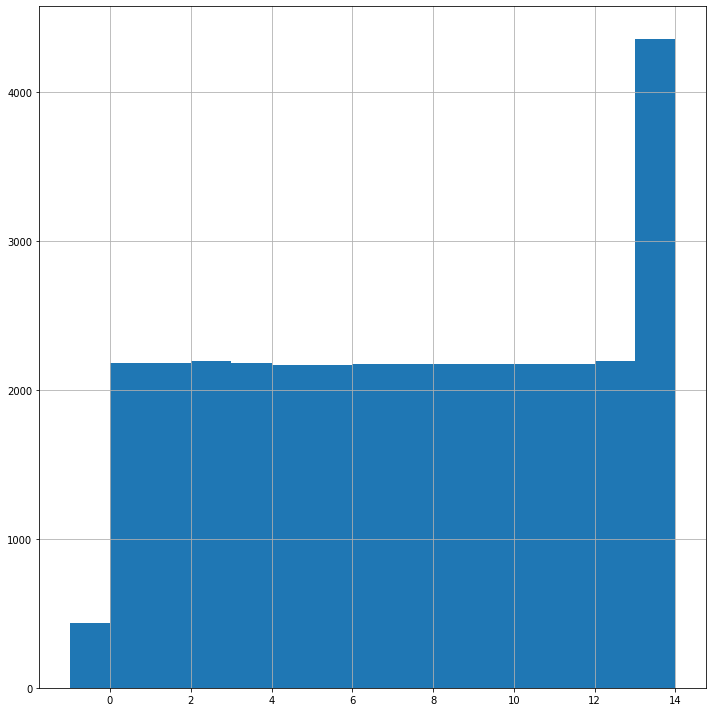

In [25]:
rcParams['figure.figsize'] = 10, 10 
train['tfrecord'].hist(bins=15);
plt.tight_layout()
plt.show()

In [8]:
train['tfrecord'].value_counts(sort=False)

 0     2182
 1     2185
 2     2193
 3     2182
 4     2167
 5     2171
 6     2175
 7     2174
 8     2177
 9     2178
 10    2174
 11    2176
 12    2198
 13    2186
 14    2174
-1      434
Name: tfrecord, dtype: int64

In [39]:
# skf = StratifiedKFold(n_splits=3, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)
train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,2,2592,1936,365
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,11,6000,4000,798
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,3,1872,1053,931
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,11,1872,1053,860


In [40]:
train_df[train_df.tfrecord == -1]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
912,ISIC_0378118,IP_4488328,male,40.0,upper extremity,unknown,benign,0,-1,6000,4000,78
1214,ISIC_0467724,IP_4488328,male,40.0,torso,unknown,benign,0,-1,6000,4000,78
2037,ISIC_0707446,IP_7651325,female,70.0,lower extremity,unknown,benign,0,-1,6000,4000,432
3615,ISIC_1192253,IP_5205991,NaN,NaN,upper extremity,unknown,benign,0,-1,6000,4000,37
4213,ISIC_1368313,IP_5295861,male,70.0,torso,unknown,benign,0,-1,6000,4000,16
...,...,...,...,...,...,...,...,...,...,...,...,...
32845,ISIC_9913667,IP_3402498,male,65.0,torso,unknown,benign,0,-1,6000,4000,470
32857,ISIC_9917477,IP_5889408,female,45.0,torso,unknown,benign,0,-1,6000,4000,65
32909,ISIC_9933282,IP_8575171,male,40.0,lower extremity,unknown,benign,0,-1,5184,3456,1020
32961,ISIC_9952408,IP_5295861,male,70.0,torso,unknown,benign,0,-1,6000,4000,16


In [41]:
train_df = train_df[train_df.tfrecord != -1]
train_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,2,2592,1936,365
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,11,6000,4000,798
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,3,1872,1053,931
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,11,1872,1053,860


In [42]:
sp = skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['tfrecord'].tolist())


In [43]:
#histgramでも作ってみる

In [44]:
for (train_idx, val_idx) in sp:
    df=train_df.iloc[val_idx].reset_index(drop=True)
    #rcParams['figure.figsize'] = 10, 10 
    #df['tfrecord'].hist(bins=15);
    #plt.tight_layout()
    #plt.show()
    print(df['tfrecord'].value_counts(sort=False))
    




4     2167
12    2198
6     2175
Name: tfrecord, dtype: int64
5     2171
2     2193
11    2176
Name: tfrecord, dtype: int64
8     2177
13    2186
14    2174
Name: tfrecord, dtype: int64
1     2185
9     2178
10    2174
Name: tfrecord, dtype: int64
0    2182
3    2182
7    2174
Name: tfrecord, dtype: int64


In [49]:
def TableDataPreprocess(dt):
    # One-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([dt[0]['anatom_site_general_challenge'], dt[1]['anatom_site_general_challenge']], ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    dt[0] = pd.concat([dt[0], dummies.iloc[:dt[0].shape[0]]], axis=1)
    dt[1] = pd.concat([dt[1], dummies.iloc[dt[0].shape[0]:].reset_index(drop=True)], axis=1)
    for df in dt:
        df['sex'] = df['sex'].map({'male': 1, 'female': 0})
        df['sex'] = df['sex'].fillna(-1)
        df['age_approx'] /= df['age_approx'].max()
        df['age_approx'] = df['age_approx'].fillna(0)
        df['patient_id'] = df['patient_id'].fillna(0)
    return dt

In [50]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, 
                 transforms = None,  meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description→学習に使わない
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            #X_data_np = np.array(x)
            #print("transfor前")
            #print(X_data_np.shape)
            #y_data_np = np.array(y)
            x = self.transforms(x)
            
        if self.train:
            y = self.df.loc[index]['target']
            #return (x, meta), y
            #print(y)
            #X_data_np = np.array(x)
            #print("transform後")
            #print(X_data_np.shape)
            #y_data_np = np.array(y)
            #print(y_data_np.shape)
            return (x, meta), y
        else:
            return (x, meta)
            #return x
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 50 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [94]:
train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train_df = train_df.drop(['diagnosis','benign_malignant'], axis=1)
train_df = train_df[train_df.tfrecord != -1]
train_df = train_df.drop(['width','height','patient_code'], axis=1) #ver1
train_df = train_df.reset_index()
test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')

dt = [train_df, test_df]
# One-hot encoding of anatom_site_general_challenge feature
concat = pd.concat([dt[0]['anatom_site_general_challenge'], dt[1]['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
#dt[0] = pd.concat([dt[0], dummies.iloc[:dt[0].shape[0]]], axis=1)
#dt[1] = pd.concat([dt[1], dummies.iloc[dt[0].shape[0]:].reset_index(drop=True)], axis=1)
#for df in dt:
#    df['sex'] = df['sex'].map({'male': 1, 'female': 0})
#    df['sex'] = df['sex'].fillna(-1)
#    df['age_approx'] /= df['age_approx'].max()
#    df['age_approx'] = df['age_approx'].fillna(0)
#    df['patient_id'] = df['patient_id'].fillna(0)
#[train_df, test_df] = TableDataPreprocess(dt)
#meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
#meta_features.remove('anatom_site_general_challenge')

In [95]:
train_df

,index,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,tfrecord
0,0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0,0
1,1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0,0
2,2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0,6
3,3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0,0
4,4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0,11
...,...,...,...,...,...,...,...,...
32687,33121,ISIC_9999134,IP_6526534,male,50.0,torso,0,2
32688,33122,ISIC_9999320,IP_3650745,male,65.0,torso,0,11
32689,33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,0,3
32690,33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,0,11


In [96]:
dt[0]

,index,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,tfrecord
0,0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0,0
1,1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0,0
2,2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0,6
3,3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0,0
4,4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0,11
...,...,...,...,...,...,...,...,...
32687,33121,ISIC_9999134,IP_6526534,male,50.0,torso,0,2
32688,33122,ISIC_9999320,IP_3650745,male,65.0,torso,0,11
32689,33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,0,3
32690,33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,0,11


In [97]:
dummies.iloc[:dt[0].shape[0]]

,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
32687,0,0,0,0,1,0,0
32688,0,0,0,0,1,0,0
32689,0,1,0,0,0,0,0
32690,0,1,0,0,0,0,0


In [98]:
err = pd.concat([dt[0], dummies.iloc[:dt[0].shape[0]]], axis=1)

In [99]:
err.tail(10)

,index,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,tfrecord,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
32682,33116,ISIC_9998582,IP_0414408,male,50.0,lower extremity,0,9,0,1,0,0,0,0,0
32683,33117,ISIC_9998682,IP_2516168,male,60.0,head/neck,1,3,1,0,0,0,0,0,0
32684,33118,ISIC_9998937,IP_3091321,male,40.0,head/neck,0,11,1,0,0,0,0,0,0
32685,33119,ISIC_9998965,IP_3293337,male,50.0,torso,0,3,0,0,0,0,1,0,0
32686,33120,ISIC_9999127,IP_9583707,male,20.0,torso,0,5,0,0,0,0,1,0,0
32687,33121,ISIC_9999134,IP_6526534,male,50.0,torso,0,2,0,0,0,0,1,0,0
32688,33122,ISIC_9999320,IP_3650745,male,65.0,torso,0,11,0,0,0,0,1,0,0
32689,33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,0,3,0,1,0,0,0,0,0
32690,33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,0,11,0,1,0,0,0,0,0
32691,33125,ISIC_9999806,IP_0046310,male,45.0,torso,0,4,0,0,0,0,1,0,0


In [84]:
errisnan = err.isnull()
errisnan[err.site_torso == True]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,tfrecord,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12,False,False,False,False,False,False,False,False,False,False,False,False,False,False
13,False,False,False,False,False,False,False,False,False,False,False,False,False,False
14,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32685,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32686,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32687,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32688,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [68]:
dt[1].shape

(10982, 5)

In [67]:
dummies

,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
43669,0,0,0,0,1,0,0
43670,0,0,0,0,1,0,0
43671,0,0,0,0,0,1,0
43672,0,1,0,0,0,0,0


In [61]:
train_df #32692 33126

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,tfrecord,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
0,ISIC_2637011,IP_7279968,1.0,0.500000,head/neck,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0015719,IP_3075186,0.0,0.500000,upper extremity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ISIC_0052212,IP_2842074,0.0,0.555556,lower extremity,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0068279,IP_6890425,0.0,0.500000,head/neck,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0074268,IP_8723313,0.0,0.611111,upper extremity,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,1.0,0.555556,torso,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33122,ISIC_9999320,IP_3650745,1.0,0.722222,torso,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33123,ISIC_9999515,IP_2026598,1.0,0.222222,lower extremity,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33124,ISIC_9999666,IP_7702038,1.0,0.555556,lower extremity,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
meta_features

['sex',
 'age_approx',
 'site_head/neck',
 'site_lower extremity',
 'site_oral/genital',
 'site_palms/soles',
 'site_torso',
 'site_upper extremity',
 'site_nan']

In [107]:
train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train_df = train_df.drop(['diagnosis','benign_malignant'], axis=1)
train_df = train_df[train_df.tfrecord != -1]
train_df = train_df.drop(['width','height','patient_code'], axis=1) #ver1

train_df = train_df.reset_index(drop=True)
tfrecord = train_df.loc[:,['tfrecord']]
train_df = train_df.drop(['tfrecord'], axis=1)

test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess(dt)
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]

In [108]:
tfrecord

,tfrecord
0,0
1,0
2,6
3,0
4,11
...,...
32687,2
32688,11
32689,3
32690,11


In [109]:
train_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
0,ISIC_2637011,IP_7279968,1.0,0.500000,head/neck,0,1,0,0,0,0,0,0
1,ISIC_0015719,IP_3075186,0.0,0.500000,upper extremity,0,0,0,0,0,0,1,0
2,ISIC_0052212,IP_2842074,0.0,0.555556,lower extremity,0,0,1,0,0,0,0,0
3,ISIC_0068279,IP_6890425,0.0,0.500000,head/neck,0,1,0,0,0,0,0,0
4,ISIC_0074268,IP_8723313,0.0,0.611111,upper extremity,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32687,ISIC_9999134,IP_6526534,1.0,0.555556,torso,0,0,0,0,0,1,0,0
32688,ISIC_9999320,IP_3650745,1.0,0.722222,torso,0,0,0,0,0,1,0,0
32689,ISIC_9999515,IP_2026598,1.0,0.222222,lower extremity,0,0,1,0,0,0,0,0
32690,ISIC_9999666,IP_7702038,1.0,0.555556,lower extremity,0,0,1,0,0,0,0,0


In [110]:
ImgNm = train_df[['image_name']]
ImgNm

,image_name
0,ISIC_2637011
1,ISIC_0015719
2,ISIC_0052212
3,ISIC_0068279
4,ISIC_0074268
...,...
32687,ISIC_9999134
32688,ISIC_9999320
32689,ISIC_9999515
32690,ISIC_9999666


In [113]:
metaval_ID = ImgNm
metaval_ID.loc[:,"target"] = 0
metaval_ID

/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,image_name,target
0,ISIC_2637011,0
1,ISIC_0015719,0
2,ISIC_0052212,0
3,ISIC_0068279,0
4,ISIC_0074268,0
...,...,...
32687,ISIC_9999134,0
32688,ISIC_9999320,0
32689,ISIC_9999515,0
32690,ISIC_9999666,0


In [102]:
test_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
0,ISIC_0052060,IP_3579794,1,0.777778,NaN,0,0,0,0,0,0,1
1,ISIC_0052349,IP_7782715,1,0.444444,lower extremity,0,1,0,0,0,0,0
2,ISIC_0058510,IP_7960270,0,0.611111,torso,0,0,0,0,1,0,0
3,ISIC_0073313,IP_6375035,0,0.555556,torso,0,0,0,0,1,0,0
4,ISIC_0073502,IP_0589375,0,0.500000,lower extremity,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,1,0.444444,torso,0,0,0,0,1,0,0
10978,ISIC_9996992,IP_4890115,1,0.388889,torso,0,0,0,0,1,0,0
10979,ISIC_9997917,IP_2852390,1,0.277778,upper extremity,0,0,0,0,0,1,0
10980,ISIC_9998234,IP_8861963,1,0.722222,lower extremity,0,1,0,0,0,0,0


## 2019データ確認

In [8]:
df2019 = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train_2019year.csv')

In [9]:
df2019

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767
...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,-1,female,85.0,head/neck,BCC,benign,0,19,1024,1024
25327,ISIC_0073248,-1,male,65.0,anterior torso,BKL,benign,0,7,1024,1024
25328,ISIC_0073249,-1,male,70.0,lower extremity,MEL,malignant,1,9,1024,1024
25329,ISIC_0073251,-1,female,55.0,palms/soles,NV,benign,0,15,1024,1024


In [6]:
df2019 = df2019[df2019.target ==1]
len(df2019)

4522

In [11]:
df2019_tf = df2019[df2019.tfrecord == 29]
df2019_tf

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
13008,ISIC_0053594,-1,male,70.0,oral/genital,MEL,malignant,1,29,1024,1024
13014,ISIC_0053602,-1,male,70.0,anterior torso,SCC,benign,0,29,1024,1024
13017,ISIC_0053611,-1,male,45.0,upper extremity,MEL,malignant,1,29,1024,1024
13024,ISIC_0053626,-1,male,40.0,head/neck,BCC,benign,0,29,1024,1024
13079,ISIC_0053710,-1,female,10.0,lower extremity,NV,benign,0,29,1024,1024
...,...,...,...,...,...,...,...,...,...,...,...
25223,ISIC_0073086,-1,male,40.0,anterior torso,NV,benign,0,29,1024,1024
25229,ISIC_0073100,-1,male,70.0,head/neck,BKL,benign,0,29,1024,1024
25232,ISIC_0073104,-1,female,30.0,lower extremity,BKL,benign,0,29,1024,1024
25318,ISIC_0073235,-1,female,45.0,anterior torso,BKL,benign,0,29,1024,1024


In [13]:
df2019_tf = df2019[df2019.tfrecord == -1]
len(df2019_tf)

59

## グレースケール確認

In [3]:
face = cv2.imread(SIIM_ISIC_Melanoma_Classification + "pad_jpg/train_agm/64_64_merge_BGR2GRAY/ISIC_0000070.jpg")
face = np.array(face)
face.shape

(64, 64, 3)

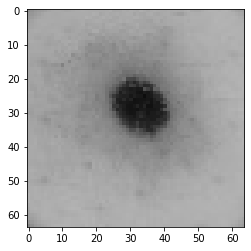

In [4]:
plt.imshow(face)
plt.show()

In [5]:
face = cv2.imread(SIIM_ISIC_Melanoma_Classification + "pad_jpg/train/64_64_merge/ISIC_0000070.jpg")
face = np.array(face)
face.shape

(64, 64, 3)

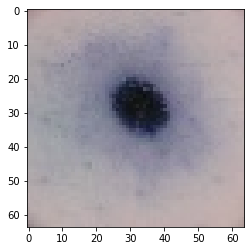

In [6]:
plt.imshow(face)
plt.show()